# 신경망 모델 훈련

## 손실 곡선

> History 클래스 객체

인공 신경망 모델은 손실 함수를 최적화한다.

따라서 인공 신경망 모델을 평가할 때는 정확도와 손실을 함께 확인해야 한다.

케라스의 신경망 모델을 학습하는 fit() 메서드를 실행하면 History 클래스 객체를 반환한다.

해당 객체에는 history 딕셔너리가 존재하는데, 이 딕셔너리는 훈련 세트에 대한 정확도와 손실을 가지고 있다.

이 값들을 이용해서 인공 신경망 모델의 epoch 진행 횟수마다 훈련 세트에 대한 정확도와 손실을 확인할 수 있다.

In [ ]:
from tensorflow import keras

In [ ]:
# 패션 mnist 데이터 셋 불러오기
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# 전처리
train_scaled = train_input / 255.0

In [ ]:
# 훈련 세트로 검증 세트를 만들기
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [ ]:
# 인공 신경망 모델을 반환하는 함수를 정의
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation="relu")) # hidden layer
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation="softmax")) # output layer
    return model

In [ ]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=5, verbose=0) # fit() 메서드가 반환하는 History 클래스 객체

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


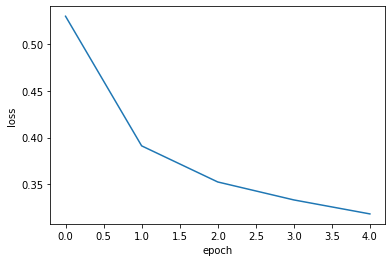

In [ ]:
# 훈련 세트에 대한 손실을 그래프로 그리기
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

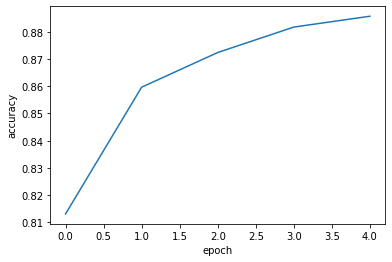

In [ ]:
# 훈련 세트에 대한 정확도를 그래프로 그리기
plt.plot(history.history["accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

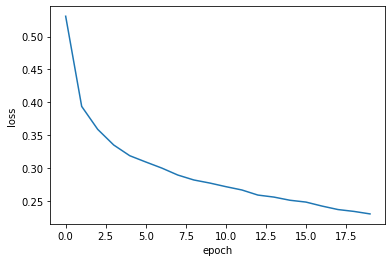

In [ ]:
# epoch를 20으로 늘려서 모델을 훈련하고 훈련 세트에 대한 손실 그래프를 그리기
model = model_fn()
model.compile(loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## 검증 손실

> 인공 신경망 모델의 과소/과대적합 판단

인공 신경망 모델의 과소/과대적합을 판단하기 위해서는 훈련 세트에 대한 정확도와 손실뿐만 아니라, 검증 세트에 대한 정확도와 손실도 확인해야 한다.

이러한 작업을 수행하기 위해서 compile() 메서드의 validation_data 매개변수에 검증 세트를 지정하면 History 클래스 객체의 history 딕셔너리에서 훈련 세트에 대한 정확도와 손실과 검증 세트에 대한 정확도와 손실도 확인할 수 있다.

이 값들을 이용해서 인공 신경망 모델의 과소/과대적합 여부를 판단할 수 있다.

In [ ]:
model = model_fn()
model.compile(loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(
    train_scaled, train_target, 
    epochs=20, 
    verbose=0, 
    validation_data=(val_scaled, val_target) # epoch마다 검증 손실을 계산
)

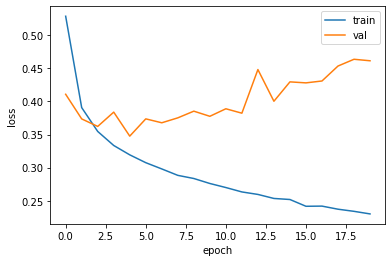

In [ ]:
# 훈련 손실과 검증 손실을 한 그래프에 그려서 과소/과대적합 여부를 판단
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

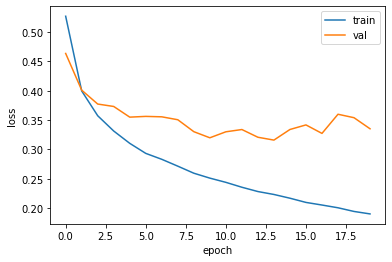

In [ ]:
# Adam 옵티마이저를 적용
model = model_fn()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

## 드롭아웃

> 드롭아웃 (dropout)

드롭아웃은 인공 신경망 모델의 과대적합을 막기 위한 규제 방법이다.

keras.layers 패키지의 Dropout 클래스를 이용해서 드롭아웃 층을 모델에 추가할 수 있다.

드롭아웃은 은닉층 뉴런의 출력을 랜덤하게 0으로 만들어서 과대적합을 막는다.

드롭아웃이 과대적합을 막는 이유로 크게 두가지 해석이 있는데, 첫번째는 은닉층 뉴런의 출력을 랜덤하게 0으로 만들면 특정 뉴런에 과도하게 의존하는 것을 해소할 수 있으며 모든 입력값에 주의를 기울일 수 있기 때문이고, 두번째는 은닉층 뉴런의 출력을 랜덤하게 0으로 만들면 2개의 모델을 앙상블하는 효과를 가져올 수 있다는 것이다.

얼마나 많은 뉴런을 드롭아웃할 것인지는 하이퍼파라미터를 통해서 결정해야 한다.

드롭아웃은 모델의 훈련 과정에서만 수행되어야 한다.

모델의 평가나 예측 단계에서는 드롭아웃이 수행되서는 안 된다.

텐서플로와 케라스는 모델의 평가나 예측 단계에서 자동으로 드롭아웃 층을 무시하도록 구현되어 있다.

In [ ]:
# 드롭아웃 층을 추가한 모델을 생성
model = model_fn(keras.layers.Dropout(0.3)) # 30% 뉴런을 모델 훈련 시 드롭아웃
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


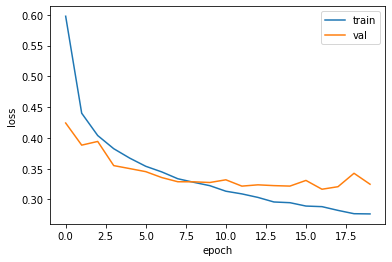

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_scaled, train_target, 
    epochs=20, 
    verbose=0, 
    validation_data=(val_scaled, val_target)
)

# 훈련 손실과 검증 손실을 그래프로 그리기
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

## 모델 저장과 복원

위의 결과에서 검증 손실이 10번째 epoch부터 증가하기 시작하기 때문에 epoch를 10로 설정해서 모델을 다시 훈련해야 한다.

이렇게 훈련한 모델은 다음에 사용할 수 있도록 저장하고 복원할 수 있다.

> 모델 파라미터를 저장하고 복원하기

훈련된 모델 파라미터를 저장하고 복원할 수 있다.

캐라스 모델은 save_weights() 메서드를 사용해서 모델 파라미터를 파일에 저장할 수 있다.

파일의 포맷은 텐서플로의 체크포인트 포맷이지만, 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

또한 load_weights() 메서드를 사용해서 파일에 저장한 모델 파라미터를 복원할 수 있다.

이때 주의할 점은 저장할 당시의 모델 구조와 복원 대상의 모델 구조는 정확하게 동일해야 한다.

> 모델과 모델 파라미터를 함께 저장하고 복원하기

훈련된 모델 파라미터뿐만 아니라 모델 자체도 저장하고 복원할 수 있다.

케라스 모델은 save() 메서드를 사용해서 모델 파라미터와 모델을 파일에 저장할 수 있다.

파일의 포맷은 텐서플로의 SavedModel 포맷이지만, 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

또한 케라스가 제공하는 load_model() 함수를 사용해서 파일에 저장한 모델 파라미터와 모델을 복원할 수 있다.

이때 load_model() 함수는 모델 파라미터 뿐만 아니라 모델 구조와 옵티마이저 상태까지 모두 복원한다.

모델의 evaluate() 메서드를 사용하기 위해서는 compile() 메서드를 반드시 실행해야 한다.

하지만 load_model() 함수로 복원한 모델은 모델의 모든 정보가 복원되기 때문에 바로 evaluate() 메서드를 사용할 수 있다.

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history = model.fit(
    train_scaled, train_target, 
    epochs=10, 
    verbose=0, 
    validation_data=(val_scaled, val_target)
)

In [ ]:
# 모델 파라미터를 파일에 저장
model.save_weights("model-weights.h5")

In [ ]:
# 모델 파라미터와 모델을 함께 파일에 저장
model.save("model-whole.h5")

In [ ]:
# 파일이 제대로 생성되었는지 확인
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Jan 13 11:06 model-weights.h5
-rw-r--r-- 1 root root 982664 Jan 13 11:06 model-whole.h5


In [ ]:
# 훈련하지 않은 새로운 모델을 만들고, model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights("model-weights.h5")

In [ ]:
import numpy as np

# 넘파이 argmax() 함수는 배열에서 가장 큰 원소의 인덱스 값을 반환한다.
# 검증 세트에는 12000개의 샘플들이 존재하기 때문에 predict() 메서드가 반환하는 넘파이 배열의 크기는 (12000, 10) 이다.
# axis=1 매개변수를 지정하면 열을 따라서 각 행의 최대값의 인덱스를 반환한다.
val_labels = np.argmax(model.predict(val_scaled), axis=1)
print(val_labels.shape)

# 두 넘파이 배열의 각 원소를 브로드캐스팅으로 비교해서 같으면 1, 다르면 0
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 1ms/step
(12000,)
0.88


In [ ]:
# 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도를 출력
model = keras.models.load_model("model-whole.h5")
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3319 - accuracy: 0.8800


[0.33190813660621643, 0.8799999952316284]

## 콜백

> 콜백 (callback)

콜백은 딥러닝 모델 훈련 중 어떠한 작업을 수행할 수 있게 하는 객체이다.

keras.callbacks 패키지 아래의 클래스들로 콜백 객체를 사용할 수 있다.

> ModelCheckpoint 콜백 클래스

모델을 훈련할 때 ModelCheckpoint 콜백을 사용하면 기본적으로 각 epoch마다 모델을 파일에 저장한다.

save_best_only 매개변수를 True로 지정하면 모델을 훈련할 때 가장 낮은 검증 점수를 기록한 모델만 저장하게 된다.

하지만 모든 epoch를 전부 수행하기 때문에 시간이 오래 걸릴 수 있다.

따라서 컴퓨터의 자원과 시간을 절약하기 위해서 '조기 종료'를 사용할 수 있다. 

> EarlyStopping 콜백 클래스

조기 종료(early stopping)는 모델의 과대적합이 발생하기 전에 훈련을 멈추는 것이다.

조기 종료를 통해서 모델의 과대적합을 막기 때문에 모델 규제의 한 종류로 볼 수 있다.

EarlyStopping 콜백 클래스를 사용해서 훈련 조기 종료를 할 수 있다.

patience 매개변수는 모델의 검증 점수가 상승하는 것을 참을 epoch 횟수이다.

만약 patience=2로 지정한다면, 검증 점수가 연속으로 2번 상승하면 훈련을 조기 종료 한다.

restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 점수를 기록한 모델의 파라미터로 되돌리게 된다.

ModelCheckpoint 콜백과 EarlyStopping 콜백은 fit() 메서드의 callbacks 매개변수에 리스트로 지정하면 된다.

두 콜백을 사용하면 모델 훈련 시 가장 낮은 검증 점수를 기록한 모델을 얻을 수 있으며, 또한 컴퓨팅 자원과 시간을 절약할 수 있다.

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy", 
    metrics="accuracy"
)

# ModelCheckpoint 콜백 객체 생성
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-model.h5", save_best_only=True)

model.fit(
    train_scaled, train_target, 
    epochs=20, 
    verbose=0, 
    validation_data=(val_scaled, val_target), 
    callbacks=[checkpoint_cb]
)

In [ ]:
# 모델을 복원하고 검증 세트에 대해서 평가
model = keras.models.load_model("best-model.h5")
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3158 - accuracy: 0.8882


[0.3158285617828369, 0.8882499933242798]

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

# ModelCheckpoint 콜백 객체 생성
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-model.h5", save_best_only=True)
# EarlyStopping 콜백 객체 생성
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(
    train_scaled, train_target, 
    epochs=20,
    verbose=0, 
    validation_data=(val_scaled, val_target), 
    callbacks=[checkpoint_cb, early_stopping_cb]
)

In [ ]:
# 몇 번째 epoch에서 조기 종료를 했는지 확인
# 12, 즉 13번째 epoch에서 조기 종료 했기 때문에 11번째 epoch의 모델이 저장된다.
print(early_stopping_cb.stopped_epoch)

12


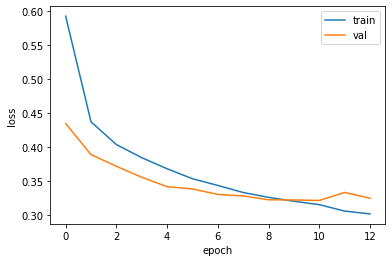

In [ ]:
# 훈련 손실과 검증 손실을 그래프로 그리기
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3216 - accuracy: 0.8789


[0.32155677676200867, 0.8789166808128357]